In [1]:
from pennylane import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pennylane as qml
import seaborn as sns
from sklearn.svm import SVC
import matplotlib as mpl
import warnings
from itertools import product
import time
from jax_utils import square_kernel_matrix_jax, kernel_matrix_jax, target_alignment_jax
from utils import get_scores

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import optax

np.random.seed(1359)

In [2]:
jax.devices()

2023-03-02 16:46:59.339410: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[CpuDevice(id=0)]

In [20]:
iris_data = load_iris()
X = iris_data.data
Y = iris_data.target
classes = [0,1,2]
n_classes = len(classes)

X = np.pad(X, ((0,0),(0,2)))

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
X_train.shape, X_test.shape

((90, 6), (60, 6))

In [21]:
def feature_map(x, params, n_layers, n_wires):
    """The embedding ansatz"""
    steps = x.shape[0]//3
    qubits = list(range(n_wires))
    
    for q in qubits:
        qml.Hadamard(wires=q)
    
    for l in range(n_layers):
        for q in qubits:
            for i in range(steps):
                z = x[3*i:3*i+3]*params[l,q,0,3*i:3*i+3] + params[l,q,1,3*i:3*i+3]
                qml.RZ(z[0], wires=q)
                qml.RY(z[1], wires=q)
                qml.RZ(z[2], wires=q)
                
        if (l & 1):
            for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
                qml.CZ((q0,q1))
        else:
            for q0, q1 in zip(qubits[0::2], qubits[1::2]):
                qml.CZ((q0,q1))

In [22]:
n_l = 2
n_w = 4
in_shape = 6

dev = qml.device("default.qubit.jax", wires=n_w)
params_shape = (n_l,n_w,2,in_shape)
params = np.random.uniform(0, 2 * np.pi, params_shape, requires_grad=True)

In [23]:
@qml.qnode(dev, interface = 'jax')
def kernel_circuit(x1, x2, params):
    feature_map(x1, params, n_l, n_w)
    qml.adjoint(feature_map)(x2, params, n_l, n_w)
    return qml.probs(wires=range(n_w))

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [24]:
print(qml.draw(kernel_circuit)(X_train[0], X_train[1], params))

0: ──H──RZ(2.06)──RY(4.70)──RZ(4.64)──RZ(5.86)──RY(2.21)──RZ(6.01)─╭●──RZ(3.24)───RY(6.04)──RZ(2.39)
1: ──H──RZ(5.58)──RY(4.68)──RZ(4.19)──RZ(6.33)──RY(4.83)──RZ(3.19)─╰Z──RZ(3.40)───RY(4.67)──RZ(1.22)
2: ──H──RZ(6.90)──RY(5.95)──RZ(7.49)──RZ(9.33)──RY(4.23)──RZ(6.12)─╭●──RZ(10.30)──RY(5.92)──RZ(4.74)
3: ──H──RZ(4.03)──RY(4.59)──RZ(3.23)──RZ(7.51)──RY(4.27)──RZ(1.38)─╰Z──RZ(1.32)───RY(6.34)──RZ(8.39)

───RZ(9.16)──RY(3.90)──RZ(4.90)────╭Z─╭Z†──RZ(4.90)†──RY(3.90)†──RZ(5.40)†──RZ(0.96)†──RY(6.97)†
───RZ(1.99)──RY(4.41)──RZ(4.60)─╭●─│──│───╭●──────────RZ(4.60)†──RY(4.41)†──RZ(0.57)†──RZ(0.13)†
───RZ(8.85)──RY(2.54)──RZ(1.42)─╰Z─│──│───╰Z†─────────RZ(1.42)†──RY(2.54)†──RZ(5.26)†──RZ(0.99)†
───RZ(3.86)──RY(5.66)──RZ(6.23)────╰●─╰●───RZ(6.23)†──RY(5.66)†──RZ(1.18)†──RZ(3.43)†──RY(6.42)†

───RZ(2.08)†────────────╭●───RZ(6.01)†──RY(2.21)†──RZ(4.44)†──RZ(2.01)†──RY(5.97)†──RZ(0.59)†──H†─┤
───RY(4.96)†──RZ(1.78)†─╰Z†──RZ(3.19)†──RY(4.83)†──RZ(6.14)†──RZ(0.55)†──RY(6.07)†──RZ(3.19)†──H†─┤
───RY(

In [25]:
jit_kernel = jax.jit(kernel)

In [26]:
start = time.time()

svms = []
for i in classes:
    print(f"class {i}")
    y_onevsall = np.where(y_train == i, 1, -1)
    y_onevsall_test = np.where(y_test == i, 1, -1)
    
    params = np.random.uniform(0, 2 * np.pi, params_shape, requires_grad=True)
    
    init_kernel = lambda x1, x2: jit_kernel(x1, x2, params)
    kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)
    svms.append(SVC(probability=True, kernel=kernel_matrix).fit(X_train, y_onevsall))
    
    accuracy_train = svms[i].score(X_train, y_onevsall)
    print(f"The accuracy of the kernel for class {i} with random parameters is {accuracy_train:.3f}")

    accuracy_test = svms[i].score(X_test, y_onevsall_test)
    print(f"The accuracy of the kernel for class {i} with random parameters is {accuracy_test:.3f}")

train_f1_score, test_f1_score = get_scores(svms, X_train, y_train, X_test, y_test)
end = time.time()
print("Duration:", end-start)

class 0
The accuracy of the kernel for class 0 with random parameters is 1.000
The accuracy of the kernel for class 0 with random parameters is 1.000
class 1
The accuracy of the kernel for class 1 with random parameters is 0.978
The accuracy of the kernel for class 1 with random parameters is 0.967
class 2
The accuracy of the kernel for class 2 with random parameters is 0.978
The accuracy of the kernel for class 2 with random parameters is 0.933
F1 score on train set: 0.978
F1 score on test set: 0.950
Duration: 4.386536121368408


In [31]:
def run(features_train, labels_train, features_test, labels_test, params):
    
    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(params)

    for i in range(500):
        # Choose subset of datapoints to compute the KTA on.
        subset = np.random.choice(list(range(len(features_train))), 4)
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment_jax(
            features_train[subset],
            labels_train[subset],
            lambda x1, x2: jit_kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        
        # Optimization step
        grads = jax.grad(cost)(params)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        # Report the alignment on the full dataset every 50 steps.
        if (i + 1) % 50 == 0:
            current_alignment = target_alignment_jax(
                features_train,
                labels_train,
                lambda x1, x2: jit_kernel(x1, x2, params),
                assume_normalized_kernel=True,
            )
            print(f"Step {i+1} - Alignment = {current_alignment:.3f}")
            
    # First create a kernel with the trained parameter baked into it.
    trained_kernel = lambda x1, x2: kernel(x1, x2, params)

    # Second create a kernel matrix function using the trained kernel.
    trained_kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, trained_kernel)

    # Note that SVC expects the kernel argument to be a kernel matrix function.
    svm_trained = SVC(probability=True, kernel=trained_kernel_matrix).fit(features_train, labels_train)
    
    return svm_trained

In [32]:
start = time.time()
svms_trained = []
for i in classes:
    y_onevsall = np.where(y_train == i, 1, -1)
    y_onevsall_test = np.where(y_test == i, 1, -1)
    
    params = np.random.uniform(0, 2 * np.pi, params_shape, requires_grad=True)
    svms_trained.append(run(X_train, y_onevsall, X_test, y_onevsall_test, params))
    
    accuracy_trained = svms_trained[i].score(X_train, y_onevsall)
    print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")
    
    accuracy_trained = svms_trained[i].score(X_test, y_onevsall_test)
    print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")
    
train_f1_score, test_f1_score = get_scores(svms, X_train, y_train, X_test, y_test)
end = time.time()
print("Duration:", end-start)

Step 50 - Alignment = 0.601
Step 100 - Alignment = 0.623
Step 150 - Alignment = 0.611
Step 200 - Alignment = 0.586
Step 250 - Alignment = 0.609
Step 300 - Alignment = 0.601
Step 350 - Alignment = 0.604
Step 400 - Alignment = 0.605
Step 450 - Alignment = 0.615
Step 500 - Alignment = 0.618
The accuracy of a kernel with trained parameters is 1.000
The accuracy of a kernel with trained parameters is 1.000
Step 50 - Alignment = 0.383
Step 100 - Alignment = 0.295
Step 150 - Alignment = 0.421
Step 200 - Alignment = 0.450
Step 250 - Alignment = 0.458
Step 300 - Alignment = 0.454
Step 350 - Alignment = 0.422
Step 400 - Alignment = 0.485
Step 450 - Alignment = 0.513
Step 500 - Alignment = 0.491
The accuracy of a kernel with trained parameters is 0.978
The accuracy of a kernel with trained parameters is 0.983
Step 50 - Alignment = 0.336
Step 100 - Alignment = 0.384
Step 150 - Alignment = 0.374
Step 200 - Alignment = 0.425
Step 250 - Alignment = 0.411
Step 300 - Alignment = 0.354
Step 350 - Alignm

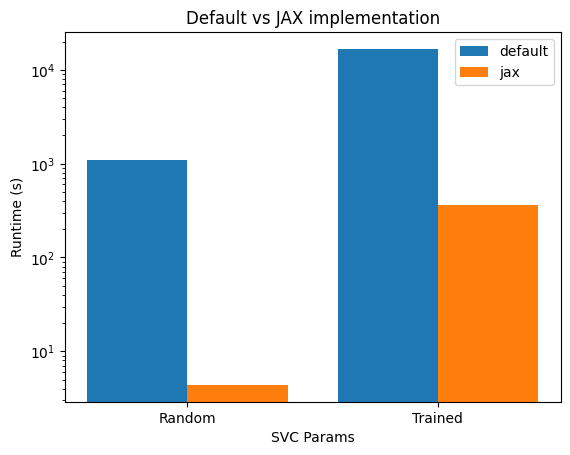

In [34]:
X = ['Random', 'Trained']
default = [1098.913788, 16692.833640]
jax = [4.386536121368408, 360.26240515708923]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, default, 0.4, label = 'default')
plt.bar(X_axis + 0.2, jax, 0.4, label = 'jax')
  
plt.xticks(X_axis, X)
plt.xlabel("SVC Params")
plt.ylabel("Runtime (s)")
plt.title("Default vs JAX implementation")
plt.yscale('log')
plt.legend()
plt.show()